In [1]:
import torch
import torchvision
model = torchvision.models.resnet18(pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [2]:
# Download an example image from the pytorch website
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [130]:
filename = "tv.jpg"
def predict_tensor(input_tensor, classes =  [ "television"]):
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)
    probabilities = torch.nn.functional.softmax(output[0], dim = 0)
    # Read the categories
    with open("imagenet_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]
    # Show top categories per image
    return [probabilities[categories.index(class_e)] for class_e in classes]

In [131]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
import numpy as np
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
preprocess_t = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.ToPILImage(),
])
input_tensor = preprocess(input_image)
og_probabilty = predict_tensor(input_tensor)
size = 224
k = 28
heat_map_dict = [[0 for i in range(size// k)] for j in range(size//k)]

null_matrix = np.zeros((k,k))
for i in range(0,size,k):
    for j in range(0,size,k):
        input_tensor_copy = torch.clone(input_tensor)
        input_tensor_copy = input_tensor_copy.numpy()
        input_tensor_copy[0, i: i + k, j:j + k ] = input_tensor_copy[1, i: i + k, i:i + k ] = input_tensor_copy[2, i: i + k, i:i + k ] = null_matrix
        cur_probs = predict_tensor(torch.from_numpy(input_tensor_copy))
        heat_map_dict[i // k][j // k] = [cur_prob.cpu().numpy() for cur_prob in cur_probs]
        del input_tensor_copy

print(og_probabilty)
print(np.array(heat_map_dict).shape)

[tensor(0.8405, device='cuda:0')]
(8, 8, 1)


[tensor(0.8405, device='cuda:0')]


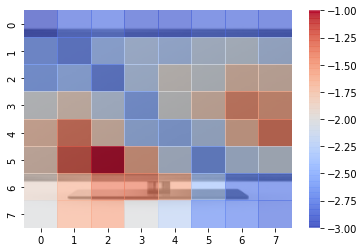

In [132]:


import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
size = 224
k = 28
heatmap_matrix = np.zeros((size//k, size//k))
classes = [ "television"]
print(og_probabilty)
for c in range(len(classes)):
    array_vals = []
    for i in range(len(heat_map_dict)):
        cur = []
        for j in range(len(heat_map_dict[0])):
            if(heat_map_dict[i][j] == 0):
                cur.append(0)
            else:
                cur.append(heat_map_dict[i][j][c].item())
        array_vals.append(cur)
    max_val = np.amax(array_vals)
    min_val = np.amin(array_vals)
    for i in range(0,size//k):
        for j in range(0,size//k):
            #heatmap_matrix[i][j] =  (array_vals[i][j] - og_probabilty[c].item())/og_probabilty[c].item()
            heatmap_matrix[i][j] =   -1 *(2 * (array_vals[i][j] -min_val)/(max_val - min_val)) - 1
    ax = sns.heatmap(heatmap_matrix, cmap="coolwarm", alpha=0.7, zorder=2)
    cimg = preprocess_t(input_image)

    ax.imshow(cimg,
         aspect=ax.get_aspect(),
         extent= ax.get_xlim() + ax.get_ylim(),
         zorder=1,)

    plt.show() 
    
        

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
size = 224
k = 4
heatmap_matrix = np.zeros((size//k, size//k))
classes = ["bottle"]
print(og_probabilty)
for c in range(len(classes)):
    array_vals = []
    for i in range(len(heat_map_dict)):
        cur = []
        for j in range(len(heat_map_dict[0])):
            if(heat_map_dict[i][j] == 0):
                cur.append(0)
            else:
                cur.append(heat_map_dict[i][j].item())
        array_vals.append(cur)
    # print(np.array(array_vals).shape)
    max_val = np.amax(array_vals)
    min_val = np.amin(array_vals)
    for i in range(0,size//k):
        for j in range(0,size//k):
            # heatmap_matrix[i][j] = (array_vals[i][j] - og_probabilty[c])/og_probabilty[c]
            heatmap_matrix[i][j] =  ((array_vals[i][j] -min_val)/(max_val - min_val))
    ax = sns.heatmap(heatmap_matrix, center=0)
    plt.show()

    cimg = preprocess_t(input_image)
    
    cimg.show()
        

[tensor(3.8647e-07, device='cuda:0'), tensor(1.3909e-05, device='cuda:0'), tensor(6.0628e-07, device='cuda:0'), tensor(3.4496e-06, device='cuda:0'), tensor(5.6228e-07, device='cuda:0'), tensor(0.9087, device='cuda:0')]


AttributeError: 'list' object has no attribute 'item'

In [4]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt


--2022-04-16 07:10:36--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0.001s  

2022-04-16 07:10:36 (12.8 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



Samoyed 0.8846220970153809
Arctic fox 0.04580506682395935
white wolf 0.04427614063024521
Pomeranian 0.0056213377974927425
Great Pyrenees 0.004651998169720173
